# MIRI PSF Photometry with Photutils

**Author**: Ori Fox<br>

**Submitted**: November, 2023<br>
**Updated**: November, 2023<br>

**Use case**: PSF Photometry using [Photutils](https://photutils.readthedocs.io/en/stable/). The purpose here is to illustrate the workflow and runtime for using Photutils in a variety of use cases.

Generally, PSF photometry for data from a space telescope is most accurately performed on pre-mosaiced data. The mosaic process changes the inherent PSF, blurring it both due to resampling and mixing PSFs at different detector positions and rotations.  Additionally, accurate theoretical PSF models (e.g., from [STPSF](https://stpsf.readthedocs.io/en/latest/)) are not available for mosaiced data. While an empirical PSF could be constructed (e.g., using Photutils [ePSFBuilder](https://photutils.readthedocs.io/en/stable/api/photutils.psf.EPSFBuilder.html)) for mosaiced data, the results will generally not be as accurate as performing PSF photometry on the pre-mosaiced data.

**NOTE:** A companion notebook exists that illustrates how to use perform PSF photometry on both Level 2 and Level 3 data using a new software program called space_phot.<br>
**Data**: MIRI Data PID 1028 (Calibration Program; Single Star Visit 006 A5V dwarf 2MASSJ17430448+6655015) and MIRI Data PID 1171 (LMC; Multiple Stars).<br>
**Tools**: photutils, stpsf, jwst <br>
**Cross-Instrument**: MIRI<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis) and can be [downloaded](https://github.com/spacetelescope/jdat_notebooks/blob/main/notebooks/MIRI/psf_photometry/miri_1028_photutils.ipynb) directly from the [JDAT Notebook Github directory](https://github.com/spacetelescope/jdat_notebooks).<br>

## Table of contents
1. [Introduction](#intro)<br>
    1.1 [Python Imports](#imports)<br>
    1.2 [Set up STPSF and Synphot](#setup)<br>
2. [Download JWST MIRI Data](#data)<br>
3. [Single Bright Object](#bso)<br>
    3.1 [Single Level 2 File](#bso2)<br>
    3.2 [Generate empirical PSF grid for MIRI F770W using STPSF](#bso3)<br>
    3.3 [PSF Photometry](#bso4)<br>
4. [Faint/Upper Limit, Single Object](#fso)<br>
    4.1 [Multiple, Level2 Files](#fso2)<br>
5. [Stellar Field (LMC)](#lmc)<br>
    5.1 [Multiple Stars, Single Level 2 File](#lmc2)<br>
    5.2 [Generate empirical PSF grid for MIRI F560W using STPSF](#grid2)<br>
    5.3 [PSF Photometry](#lmc3)<br>

# 1. Introduction <a class="anchor" id="intro"></a>

**GOALS**:<br>

Perform PSF photometry on JWST MIRI images with the [Photutils PSF Photometry tools](https://photutils.readthedocs.io/en/latest/user_guide/psf.html) using a grid of empirical PSF models from STPSF.


The notebook shows how to:<br>

* generate a [grid of empirical PSF models](https://stpsf.readthedocs.io/en/latest/psf_grids.html) from STPSF<br>
* perform PSF photometry on the image using the [PSFPhotometry class](https://photutils.readthedocs.io/en/latest/api/photutils.psf.PSFPhotometry.html#photutils.psf.PSFPhotometry)<br>

**Data**:<br>

MIRI Data PID 1028 (Calibration Program), F770W <br>
MIRI Data PID 1171 (LMC), F560W/F770W

## 1.1 Python Imports <a class="anchor" id="imports"></a>

In [1]:
import glob
import os
import shutil
import tarfile

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import stpsf
import requests
from urllib.parse import urlparse
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.nddata import extract_array
from astropy.table import Table
from astropy.visualization import simple_norm
from astroquery.mast import Observations
from jwst.datamodels import ImageModel
from photutils.aperture import CircularAperture
from photutils.background import LocalBackground, MADStdBackgroundRMS, MMMBackground
from photutils.detection import DAOStarFinder
from photutils.psf import GriddedPSFModel, PSFPhotometry

## 1.2 Download and Set up Required Data for STPSF and Synphot <a class="anchor" id="setup"></a>

In [2]:
# Set environmental variables
os.environ["STPSF_PATH"] = "./stpsf-data/stpsf-data"
os.environ["PYSYN_CDBS"] = "./grp/redcat/trds/"

# STPSF Data
stpsf_url = 'https://stsci.box.com/shared/static/kqfolg2bfzqc4mjkgmujo06d3iaymahv.gz'
stpsf_file = './stpsf-data-LATEST.tar.gz'
synphot_url = 'http://ssb.stsci.edu/trds/tarfiles/synphot5.tar.gz'
synphot_file = './synphot5.tar.gz'

stpsf_folder = './stpsf-data'
synphot_folder = './grp'


def download_file(url, dest_path, timeout=60):
    parsed_url = urlparse(url)
    if parsed_url.scheme not in ["http", "https"]:
        raise ValueError(f"Unsupported URL scheme: {parsed_url.scheme}")

    response = requests.get(url, stream=True, timeout=timeout)
    response.raise_for_status()
    with open(dest_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)


# Gather stpsf files
stpsfExist = os.path.exists(stpsf_folder)
if not stpsfExist:
    os.makedirs(stpsf_folder)
    download_file(stpsf_url, stpsf_file)
    gzf = tarfile.open(stpsf_file)
    gzf.extractall(stpsf_folder, filter='data')

# Gather synphot files
synExist = os.path.exists(synphot_folder)
if not synExist:
    os.makedirs(synphot_folder)
    download_file(synphot_url, synphot_file)
    gzf = tarfile.open(synphot_file)
    gzf.extractall('./', filter='data')

# 2. Download JWST MIRI Data <a class="anchor" id="data"></a>

In [3]:
# Download Proposal ID 1028 F770W data

# Define source and destination directories
source_dir = 'mastDownload/JWST/'
destination_dir = 'mast/01028/'

if os.path.isdir(destination_dir):
    print(f'Data already downloaded to {os.path.abspath(destination_dir)}')
else:
    # Query the MAST (Mikulski Archive for Space Telescopes) database for observations
    # with proposal ID 1028 and the F770W filter
    obs = Observations.query_criteria(proposal_id=1028, filters=['F770W'])
    
    # Get a list of products associated with the located observation
    plist = Observations.get_product_list(obs)
    
    # Filter the product list to include only specific product subgroups
    fplist = Observations.filter_products(plist, productSubGroupDescription=['CAL', 'I2D', 'ASN'])
    
    # Download the selected products from the MAST database
    Observations.download_products(fplist)
    
    # Create the destination directory
    os.makedirs(destination_dir)
    
    # Use glob to find all files matching the pattern
    files_to_copy = glob.glob(os.path.join(source_dir, 'j*/jw01028*'))

    # Copy the matching files to the destination directory
    for file_path in files_to_copy:
        shutil.copy(file_path, destination_dir)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


In [4]:
# Download Proposal ID 1171 F560W and F770W data

# Define source and destination directories
source_dir = 'mastDownload/JWST/'
destination_dir = 'mast/01171/'

if os.path.isdir(destination_dir):
    print(f'Data already downloaded to {os.path.abspath(destination_dir)}')
else:
    # Query the MAST (Mikulski Archive for Space Telescopes) database for observations
    # with proposal ID 1171 and the F550W and F770W filters
    obs = Observations.query_criteria(proposal_id=1171, filters=['F560W', 'F770W'])
    
    # Get a list of products associated with the located observation
    plist = Observations.get_product_list(obs)
    
    # Filter the product list to include only specific product subgroups
    fplist = Observations.filter_products(plist, productSubGroupDescription=['CAL', 'I2D', 'ASN'])
    
    # Download the selected products from the MAST database
    Observations.download_products(fplist)
    
    # Create the destination directory
    os.makedirs(destination_dir)
    
    # Use glob to find all files matching the pattern
    files_to_copy = glob.glob(os.path.join(source_dir, 'j*/jw01171*'))
    
    # Copy the matching files to the destination directory
    for file_path in files_to_copy:
        shutil.copy(file_path, destination_dir)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


# 3. Single Bright Star <a class="anchor" id="bso"></a>

The purpose of this section is to illustrate how to perform PSF photometry on a single bright star. While aperture photometry is feasible in isolated cases, the user may find PSF photometry preferable in crowded fields or complicated backgrounds.

## 3.1 Single Level 2 File <a class="anchor" id="bso2"></a>

In this example, we fit a single, bright source in a single Level 2 images. For a collection of Level 2 images, we could fit each Level 2 image individually and then average the measured fluxes.

Useful references:<br>
HST Documentation on PSF Photometry: https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/psf<br>
WFPC2 Stellar Photometry with HSTPHOT: https://ui.adsabs.harvard.edu/abs/2000PASP..112.1383D/abstract<br>
Photutils PSF Fitting Photometry: https://photutils.readthedocs.io/en/stable/user_guide/psf.html

In [5]:
# get the level 2 filenames
path = "./mast/01028/"
level2 = sorted(glob.glob(os.path.join(path, '*cal.fits')))
level2

['./mast/01028/jw01028006001_02101_00001_mirimage_cal.fits',
 './mast/01028/jw01028006001_02101_00002_mirimage_cal.fits',
 './mast/01028/jw01028006001_02101_00003_mirimage_cal.fits',
 './mast/01028/jw01028006001_02101_00004_mirimage_cal.fits']

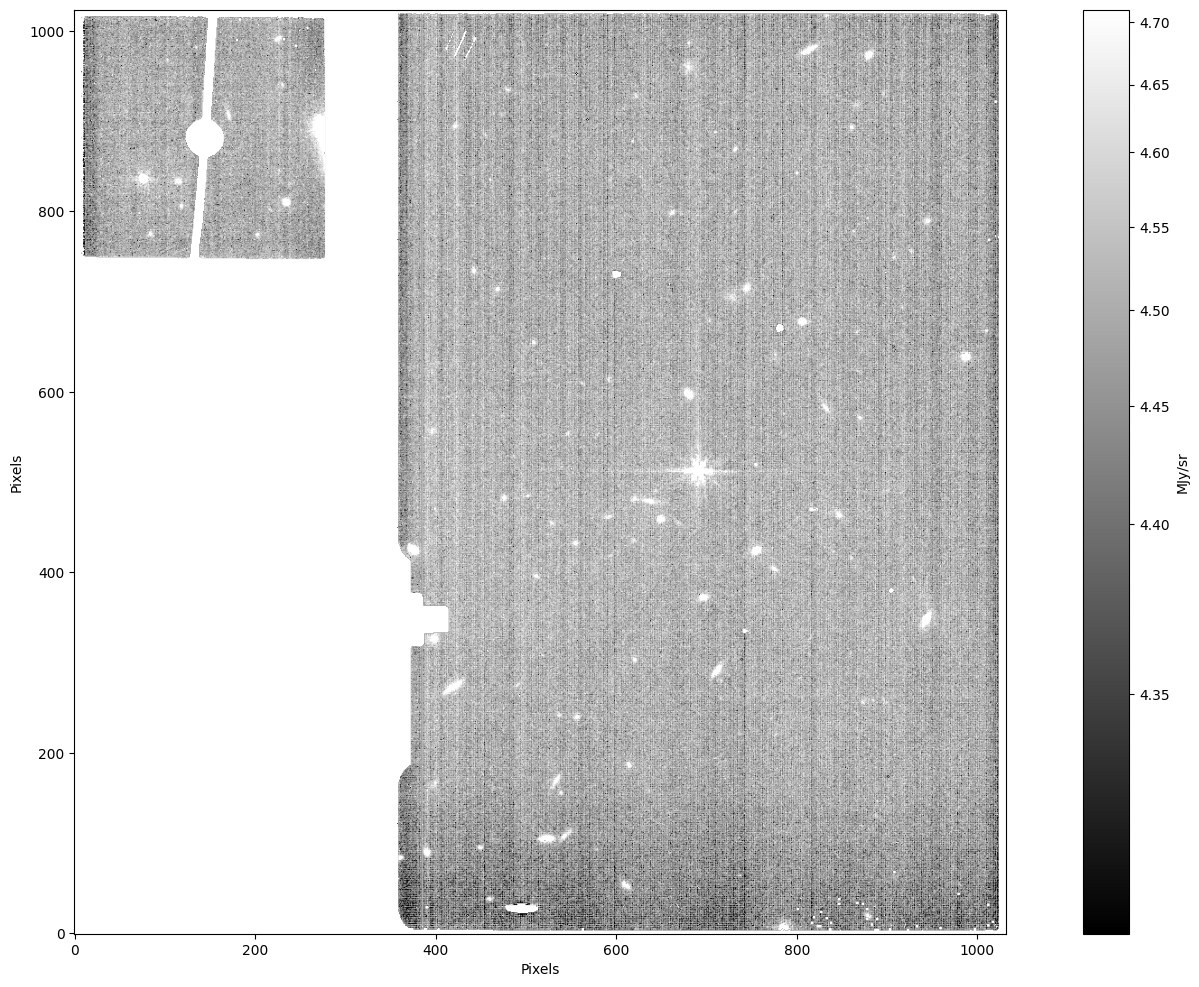

In [6]:
# display the first level-2 image
data = fits.getdata(level2[0])
norm = simple_norm(data, 'sqrt', percent=99)

fig, ax = plt.subplots(figsize=(20, 12))
im = ax.imshow(data, origin='lower', norm=norm, cmap='gray')
clb = plt.colorbar(im, label='MJy/sr')
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
plt.show()

In [7]:
# Change all DQ flagged pixels to NaN.
# Here, we'll overwrite the original CAL file.
# Reference for JWST DQ Flag Definitions: https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html
# In this case, we choose all DQ > 10, but users are encouraged to choose their own values accordingly.
filename = level2[0]
with ImageModel(filename) as model:
    model.data[model.dq >= 10] = np.nan
    model.save(filename)

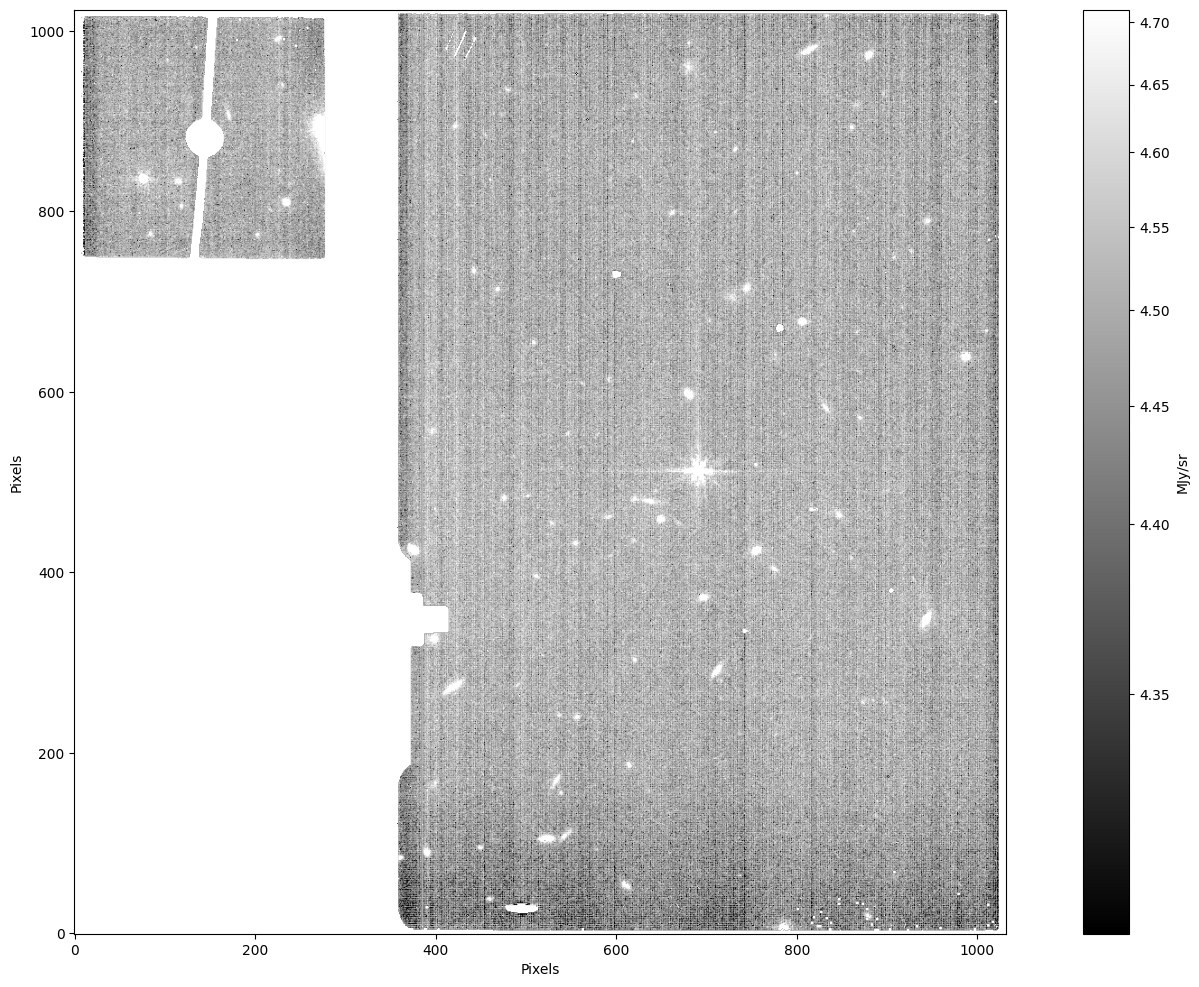

In [8]:
# Re-display the image
data = fits.getdata(level2[0])
norm = simple_norm(data, 'sqrt', percent=99)

fig, ax = plt.subplots(figsize=(20, 12))
im = ax.imshow(data, origin='lower', norm=norm, cmap='gray')
clb = plt.colorbar(im, label='MJy/sr')
ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
plt.show()

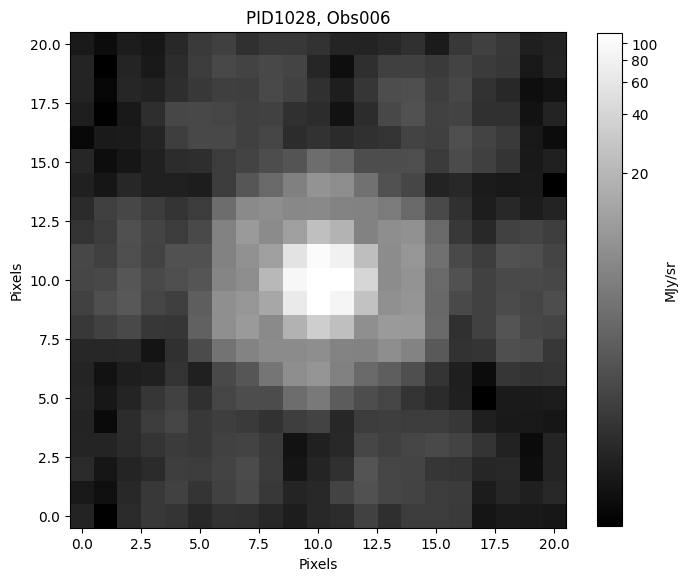

In [9]:
# Zoom in to see the source. In this case, our source is from MIRI Program ID #1028, a Calibration Program.
# We are using Visit 006, which targets the A5V dwarf 2MASSJ17430448+6655015
# Reference Link: http://simbad.cds.unistra.fr/simbad/sim-basic?Ident=2MASSJ17430448%2B6655015&submit=SIMBAD+search
source_location = SkyCoord('17:43:04.4879', '+66:55:01.837', unit=(u.hourangle, u.deg))
with ImageModel(filename) as model:
    x, y = model.meta.wcs.world_to_pixel(source_location)

cutout = extract_array(data, (21, 21), (y, x))

fig, ax = plt.subplots(figsize=(8, 8))
norm2 = simple_norm(cutout, 'log', percent=99)
im = ax.imshow(cutout, origin='lower', norm=norm2, cmap='gray')
clb = plt.colorbar(im, label='MJy/sr', shrink=0.8)
ax.set_title('PID1028, Obs006')

ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
plt.show()

## 3.2 Generate empirical PSF grid for MIRI F770W using STPSF <a class="anchor" id="bso3"></a>

Let's now use STPSF to generate an empirical grid of ePSF models for MIRI F770W.
The output will be a Photutils [GriddedPSFModel](https://photutils.readthedocs.io/en/latest/api/photutils.psf.GriddedPSFModel.html#photutils.psf.GriddedPSFModel) containing a 2x2 grid of detector-position-dependent empirical PSFs, each oversampled by a factor of 4. Note that we save the PSF grid to a FITS file (via `save=True`) called `miri_mirim_f770w_fovp101_samp4_npsf4.fits`.  To save time in future runs, we load this FITS file directly into a `GriddedPSFModel` object:

In [10]:
psfgrid_filename = 'miri_mirim_f770w_fovp101_samp4_npsf4.fits'

if not os.path.exists(psfgrid_filename):
    miri = stpsf.MIRI()
    miri.filter = 'F770W'
    miri.detector = 'MIRIM'
    psf_model = miri.psf_grid(num_psfs=4, all_detectors=False, verbose=True, save=True)
else:
    psf_model = GriddedPSFModel.read(psfgrid_filename)

psf_model


Running instrument: MIRI, filter: F770W
  Running detector: MIRIM
    Position 1/4: (0, 0) pixels


    Position 1/4 centroid: (np.float64(201.4023624749013), np.float64(201.47046390597333))
    Position 2/4: (0, 1023) pixels


    Position 2/4 centroid: (np.float64(201.30690755776234), np.float64(201.3328394993336))
    Position 3/4: (1023, 0) pixels


    Position 3/4 centroid: (np.float64(201.46001999611337), np.float64(201.57406698621335))
    Position 4/4: (1023, 1023) pixels


    Position 4/4 centroid: (np.float64(201.71435554877664), np.float64(201.48197003471248))
  Saving file: miri_mirim_f770w_fovp101_samp4_npsf4.fits


<GriddedPSFModel(flux=1., x_0=0., y_0=0.)>

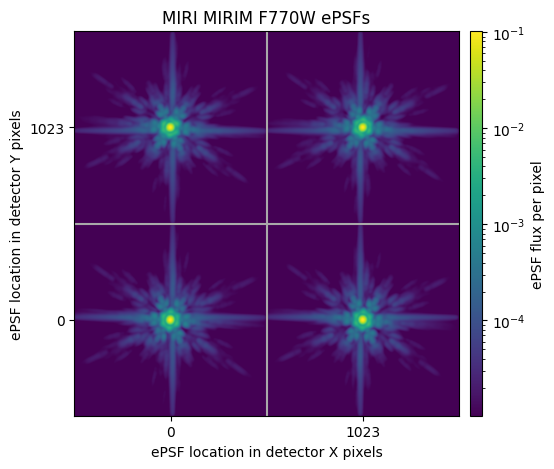

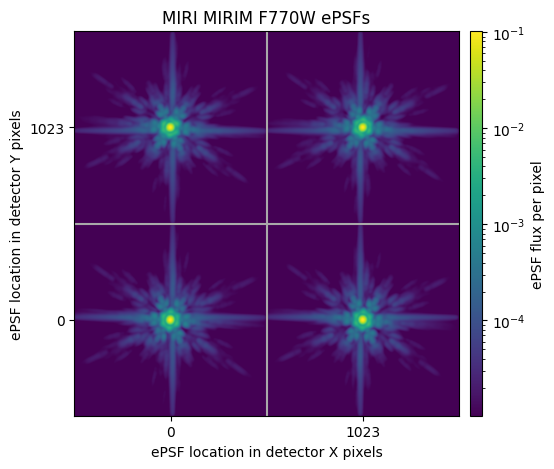

In [11]:
# display the PSF grid
psf_model.plot_grid()

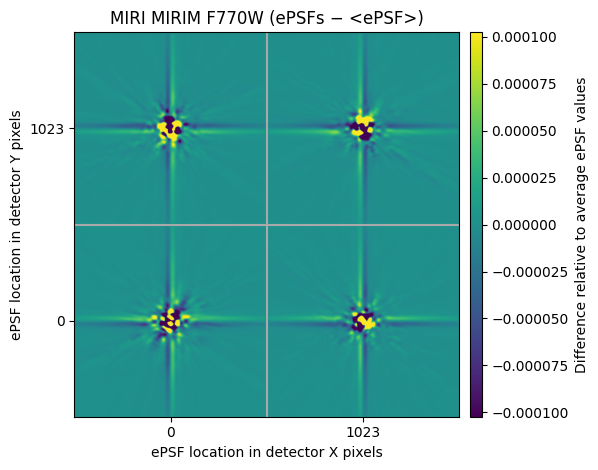

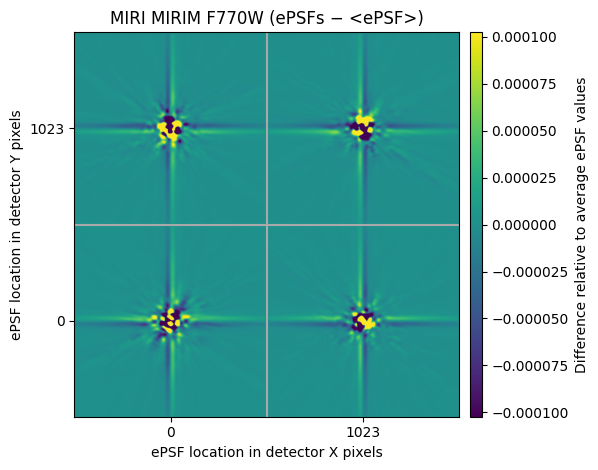

In [12]:
# display the PSF grid deltas from the mean ePSF
psf_model.plot_grid(deltas=True)

## 3.3 PSF Photometry <a class="anchor" id="bso4"></a>

Now let's use our gridded PSF model to perform PSF photometry.

In [13]:
# load data and convert units from MJy/sr to uJy
with ImageModel(filename) as model:
    unit = u.Unit(model.meta.bunit_data)
    data = model.data << unit
    error = model.err << unit

    # use pixel area map because of geometric distortion in level-2 data 
    pixel_area = model.area * model.meta.photometry.pixelarea_steradians * u.sr
    data *= pixel_area
    error *= pixel_area
    
    data = data.to(u.uJy)
    error = error.to(u.uJy)

data.unit, error.unit

(Unit("uJy"), Unit("uJy"))

To perform photometry on a single source we can input a Table containing its (x, y) position.

In [14]:
init_params = Table()
init_params['x'] = [x]
init_params['y'] = [y]
init_params

<Table length=1>
        x                 y        
     float64           float64     
----------------- -----------------
691.0126389413533 512.5838903334229

In [15]:
# we turn off the finder because we input the source position
fit_shape = 5
localbkg_estimator = LocalBackground(5, 10, bkg_estimator=MMMBackground())
psfphot = PSFPhotometry(psf_model, fit_shape, finder=None, aperture_radius=fit_shape, 
                        localbkg_estimator=localbkg_estimator, progress_bar=True)
phot = psfphot(data, error=error, init_params=init_params)
phot

<QTable length=1>
  id  group_id group_size ...        qfit                 cfit         flags
                          ...                                               
int64  int64     int64    ...      float64              float64        int64
----- -------- ---------- ... ------------------ --------------------- -----
    1        1          1 ... 0.7057654379338035 -0.017056128265791032     0

In [16]:
# convert fit flux from uJy to ABmag
flux = phot['flux_fit']
flux_err = phot['flux_err']
mag = phot['flux_fit'].to(u.ABmag)
magerr = 2.5 * np.log10(1.0 + (flux_err / flux))
magerr = magerr.value * u.ABmag
mag, magerr

(<Magnitude [17.23109481] mag(AB)>, <Magnitude [0.00119883] mag(AB)>)

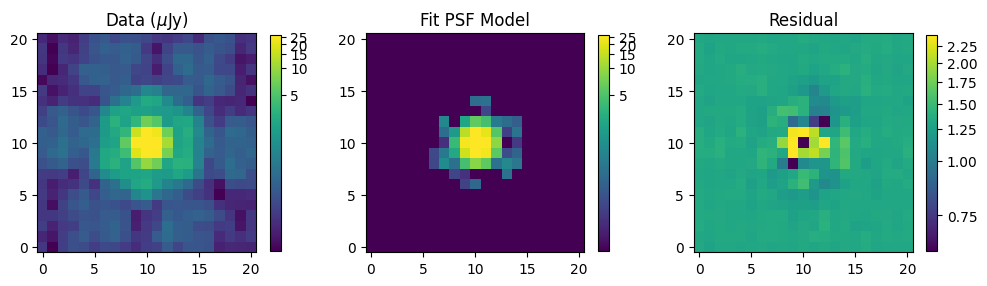

In [17]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

shape = (21, 21)
cutout1 = extract_array(data.value, shape, (y, x))
norm = simple_norm(cutout1, 'log', percent=98)
im1 = ax[0].imshow(cutout1, origin='lower', norm=norm)
ax[0].set_title(r'Data ($\mu$Jy)')
plt.colorbar(im1, shrink=0.7)

model = psfphot.make_model_image(data.shape, psf_shape=shape)
cutout2 = extract_array(model, shape, (y, x))
im2 = ax[1].imshow(cutout2, origin='lower', norm=norm)
ax[1].set_title('Fit PSF Model')
plt.colorbar(im2, shrink=0.7)

resid = psfphot.make_residual_image(data, psf_shape=shape)
cutout3 = extract_array(resid, shape, (y, x))
norm3 = simple_norm(cutout3.value, 'sqrt', percent=99)
im3 = ax[2].imshow(cutout3.value, origin='lower', norm=norm3)
ax[2].set_title('Residual')
plt.colorbar(im3, shrink=0.7)
plt.show()

# 4. Faint/Upper Limit, Single Object <a class="anchor" id="fso"></a>

The purpose of this section is to illustrate how to calculate an upper limit at a fixed (x, y) position using forced PSF photometry a blank part of the sky.

We'll use the same data as Section 3.

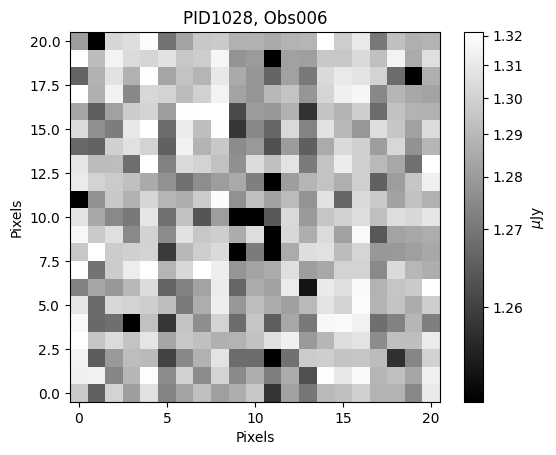

In [18]:
# load data and convert units from MJy/sr to uJy
with ImageModel(filename) as model:
    unit = u.Unit(model.meta.bunit_data)
    data = model.data << unit
    error = model.err << unit
    
    pixel_area = pixel_area = model.meta.photometry.pixelarea_steradians * u.sr
    data *= pixel_area
    error *= pixel_area
    
    data = data.to(u.uJy)
    error = error.to(u.uJy)

source_location = SkyCoord('17:43:00.0332', '+66:54:42.677', unit=(u.hourangle, u.deg))
with ImageModel(filename) as model:
    x, y = model.meta.wcs.world_to_pixel(source_location)

cutout = extract_array(data.value, (21, 21), (y, x))

fig, ax = plt.subplots()
norm = simple_norm(cutout, 'sqrt', percent=95)
im = ax.imshow(cutout, origin='lower', norm=norm, cmap='gray')
clb = plt.colorbar(im, label=r'$\mu$Jy')
ax.set_title('PID1028, Obs006')

ax.set_xlabel('Pixels')
ax.set_ylabel('Pixels')
plt.show()

In [19]:
# to perform forced photometry, we set the (x, y) source position
# AND we fix the PSF model position so that it does not vary in the fit
# (only flux will be fit)
init_params = Table()
init_params['x'] = [x]
init_params['y'] = [y]

# This requires photutils 1.11.0
psf_model_forced = psf_model.copy()
psf_model_forced.x_0.fixed = True
psf_model_forced.y_0.fixed = True
psf_model_forced.fixed

{'flux': False, 'x_0': True, 'y_0': True}

In [20]:
fit_shape = 5
localbkg_estimator = LocalBackground(5, 10, bkg_estimator=MMMBackground())
psfphot = PSFPhotometry(psf_model_forced, fit_shape, finder=None, aperture_radius=fit_shape, 
                        localbkg_estimator=localbkg_estimator, progress_bar=True)

phot = psfphot(data, error=error, init_params=init_params)
phot

<QTable length=1>
  id  group_id group_size ...        qfit               cfit        flags
                          ...                                            
int64  int64     int64    ...      float64            float64       int64
----- -------- ---------- ... ------------------ ------------------ -----
    1        1          1 ... -93.32672605807173 0.4099578318266419     4

In [21]:
# To calculate upper limit, multiply the flux_err by your desired sigma
sigma = 3.0
limit = sigma * phot['flux_err']
limit.to(u.ABmag)

<Magnitude [25.70042642] mag(AB)>

## Note: you can go significantly deeper with the Level 3 combined data product

# 5. Stellar Field (LMC) <a class="anchor" id="lmc"></a>

In this case, we are going to do the same steps as in Section 3, but for multiple stars. The purpose is to illustrate the workflow and runtime for using Photutils on a large number of stars.

## 5.1 Multiple Stars, Single Level 2 File <a class="anchor" id="lmc2"></a>

In [22]:
# Find stars in Level 3 File
path = './mast/01171/'
level3 = os.path.join(path, 'jw01171-o004_t001_miri_f560w_i2d.fits')
level3

'./mast/01171/jw01171-o004_t001_miri_f560w_i2d.fits'

In [23]:
# Get rough estimate of background (there are better ways to do background subtraction)
bkgrms = MADStdBackgroundRMS()
mmm_bkg = MMMBackground()

with ImageModel(level3) as model:
    wcs_l3 = model.meta.wcs
    std = bkgrms(model.data)
    bkg = mmm_bkg(model.data)
    data_bkgsub = model.data.copy()
    data_bkgsub -= bkg 

# Find stars
# F560W FWHM = 1.882 pix
fwhm_psf = 1.882
threshold = 5.0
daofind = DAOStarFinder(threshold=threshold * std, fwhm=fwhm_psf, exclude_border=True, min_separation=10)
found_stars = daofind(data_bkgsub)

# print first 10 rows
found_stars[:10]

<QTable length=10>
  id      xcentroid          ycentroid      ...   mag       daofind_mag     
int64      float64            float64       ... float32       float64       
----- ------------------ ------------------ ... ------- --------------------
    1  546.2615248590856  5.400907067001771 ...     nan  -0.5413295965257243
    2  789.0983970730795  6.312157835017224 ...     nan  -0.1035249124958943
    3  845.9799634503643  3.675797141070524 ...     nan   -0.179222451244508
    4  899.9897053947699  6.397798212963888 ...     nan -0.27040963162533443
    5  933.9483297710668    6.0826309686362 ...     nan  -0.2932190034185517
    6  385.6695305861909 5.6695305861908665 ...     nan  -0.8799714878560672
    7  385.3304694138091 5.6695305861908665 ...     nan  -0.8799714878560672
    8 444.15413979694966 6.5255939563821155 ...     nan  -0.5083890599860833
    9 457.96743096331807 6.5722132667441135 ...     nan -0.40185207990344185
   10 504.80151790231764  6.318931006256024 ...     nan  -0.8173711006728445

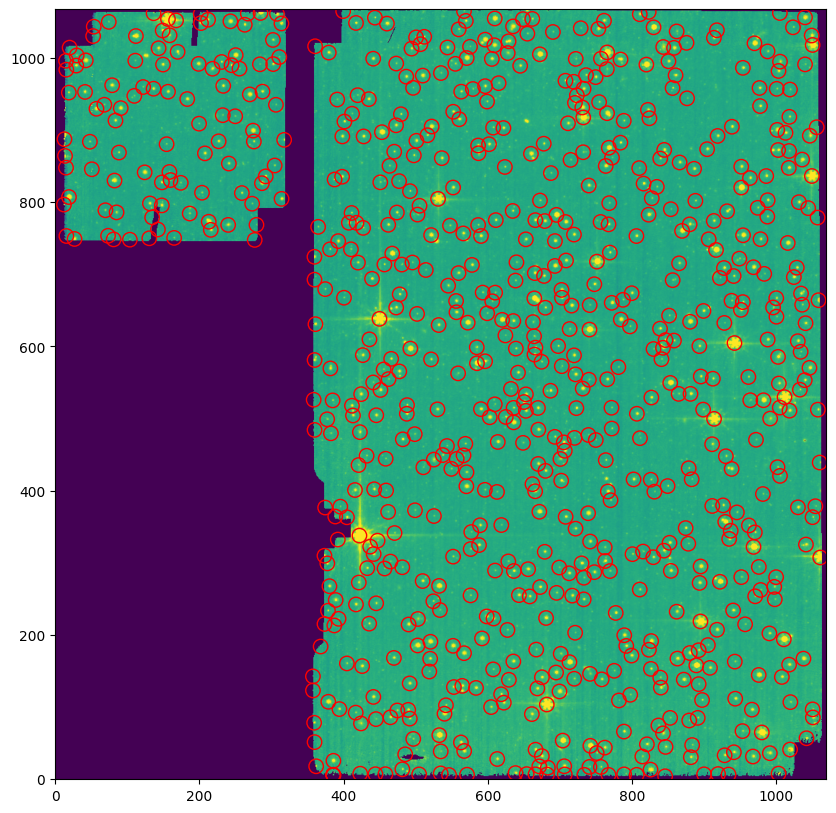

In [24]:
# plot the found stars
norm = simple_norm(data_bkgsub, 'sqrt', percent=99)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data_bkgsub, origin='lower', norm=norm)

xypos = zip(found_stars['xcentroid'], found_stars['ycentroid'])
aper = CircularAperture(xypos, r=10)
aper.plot(ax, color='red')
plt.show()

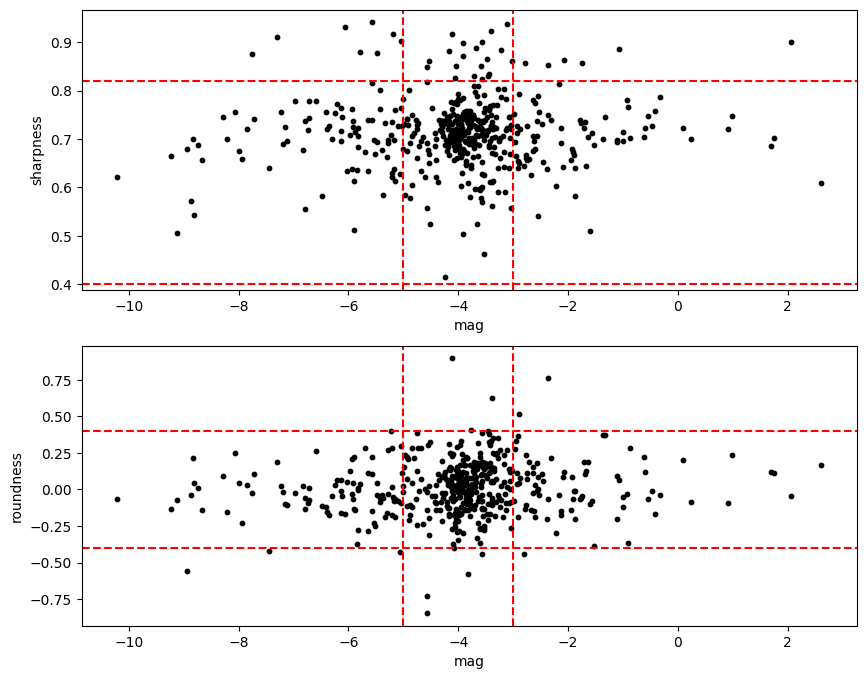

In [25]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))

ax[0].scatter(found_stars['mag'], found_stars['sharpness'], s=10, color='k')
ax[0].set_xlabel('mag')
ax[0].set_ylabel('sharpness')

ax[1].scatter(found_stars['mag'], found_stars['roundness2'], s=10, color='k')
ax[1].set_xlabel('mag')
ax[1].set_ylabel('roundness')

mag0 = -3.0
mag1 = -5.0
for ax_ in ax:
    ax_.axvline(mag0, color='red', linestyle='dashed')
    ax_.axvline(mag1, color='red', linestyle='dashed')

sh0 = 0.40
sh1 = 0.82
ax[0].axhline(sh0, color='red', linestyle='dashed')
ax[0].axhline(sh1, color='red', linestyle='dashed')

rnd0 = -0.40
rnd1 = 0.40
ax[1].axhline(rnd0, color='red', linestyle='dashed')
ax[1].axhline(rnd1, color='red', linestyle='dashed')
plt.show()

In [26]:
mask = ((found_stars['mag'] < mag0) & (found_stars['mag'] > mag1) & (found_stars['roundness2'] > rnd0)
        & (found_stars['roundness2'] < rnd1) & (found_stars['sharpness'] > sh0) 
        & (found_stars['sharpness'] < sh1) & (found_stars['xcentroid'] > 100) & (found_stars['xcentroid'] < 700)
        & (found_stars['ycentroid'] > 100) & (found_stars['ycentroid'] < 700))

found_stars_sel = found_stars[mask]

print('Number of stars found originally:', len(found_stars))
print('Number of stars in final selection:', len(found_stars_sel))

Number of stars found originally: 790
Number of stars in final selection: 63


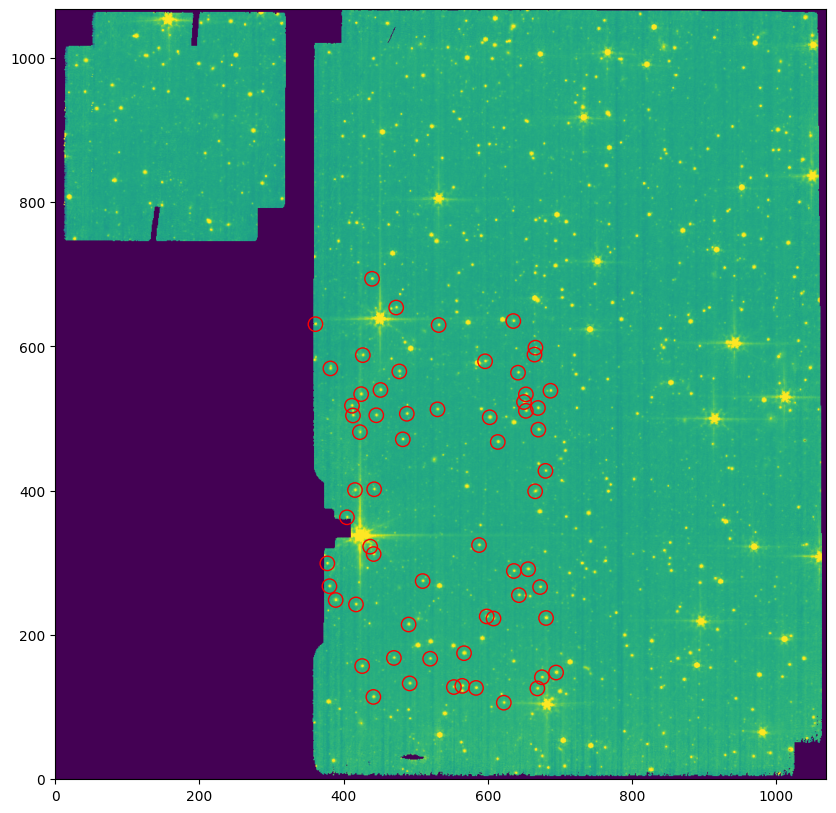

In [27]:
# plot the selected stars
norm = simple_norm(data_bkgsub, 'sqrt', percent=99)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data_bkgsub, origin='lower', norm=norm)

xypos = zip(found_stars_sel['xcentroid'], found_stars_sel['ycentroid'])
aper = CircularAperture(xypos, r=10)
aper.plot(ax, color='red')
plt.show()

## 5.2 Generate empirical PSF grid for MIRI F560W using STPSF <a class="anchor" id="grid2"></a>

In [28]:
psfgrid_filename = 'miri_mirim_f560w_fovp101_samp4_npsf4.fits'

if not os.path.exists(psfgrid_filename):
    miri = stpsf.MIRI()
    miri.filter = 'F560W'
    miri.detector = 'MIRIM'
    psf_model = miri.psf_grid(num_psfs=4, all_detectors=False, verbose=True, save=True)
else:
    psf_model = GriddedPSFModel.read(psfgrid_filename)

psf_model


Running instrument: MIRI, filter: F560W
  Running detector: MIRIM
    Position 1/4: (0, 0) pixels


    Position 1/4 centroid: (np.float64(201.39504365744267), np.float64(201.46837962104274))
    Position 2/4: (0, 1023) pixels


    Position 2/4 centroid: (np.float64(201.30209346068543), np.float64(201.31984343070144))
    Position 3/4: (1023, 0) pixels


    Position 3/4 centroid: (np.float64(201.42830769164874), np.float64(201.59926840411683))
    Position 4/4: (1023, 1023) pixels


    Position 4/4 centroid: (np.float64(201.75498594600967), np.float64(201.4970454286808))
  Saving file: miri_mirim_f560w_fovp101_samp4_npsf4.fits


<GriddedPSFModel(flux=1., x_0=0., y_0=0.)>

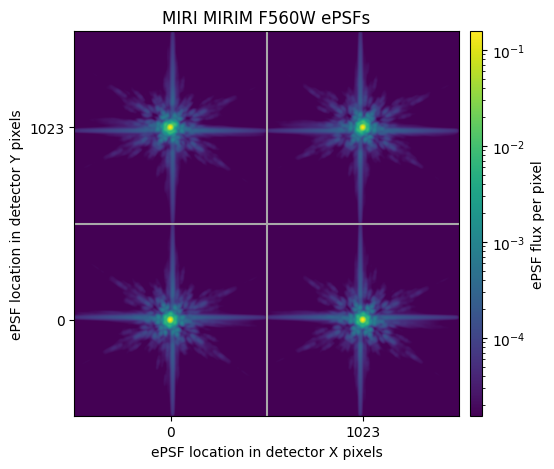

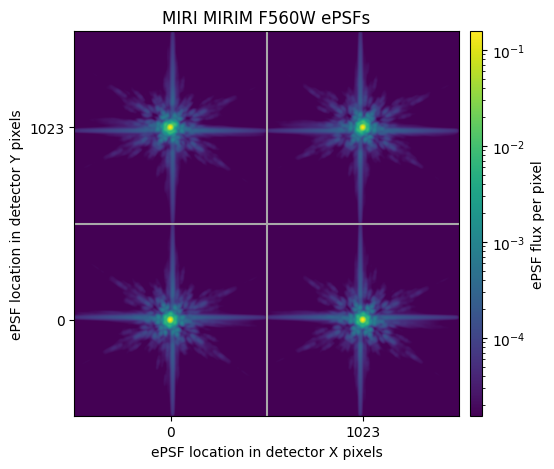

In [29]:
psf_model.plot_grid()

In [30]:
# get the level 2 image
# here, we'll use the PID 1171 files
path = "./mast/01171/"
level2 = sorted(glob.glob(os.path.join(path, 'jw01171004*cal.fits')))
filename = level2[0]
print(filename)

# load data and convert units from MJy/sr to uJy
with ImageModel(filename) as model:
    unit = u.Unit(model.meta.bunit_data)
    model.data[model.dq >= 10] = np.nan
    data = model.data << unit
    error = model.err << unit
    
    pixel_area = pixel_area = model.meta.photometry.pixelarea_steradians * u.sr
    data *= pixel_area
    error *= pixel_area
    
    data = data.to(u.uJy)
    error = error.to(u.uJy)

    wcs = model.meta.wcs

data.unit, error.unit

./mast/01171/jw01171004001_02101_00001_mirimage_cal.fits


(Unit("uJy"), Unit("uJy"))

## 5.3 PSF Photometry <a class="anchor" id="lmc3"></a>

In [31]:
# translate (x, y) positions from the level 3 image to the level 2 image
xc = found_stars_sel['xcentroid']
yc = found_stars_sel['ycentroid']
sc = wcs_l3.pixel_to_world(xc, yc)

x, y = wcs.world_to_pixel(sc)
init_params = Table()
init_params['x'] = x
init_params['y'] = y

# we need to remove stars in the masked region of
# the level-2 data
mask = x > 404
init_params = init_params[mask]

In [32]:
mask

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True, False,  True,  True,  True, False, False,
       False,  True, False,  True, False, False,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
        True, False,  True,  True,  True, False,  True,  True, False])

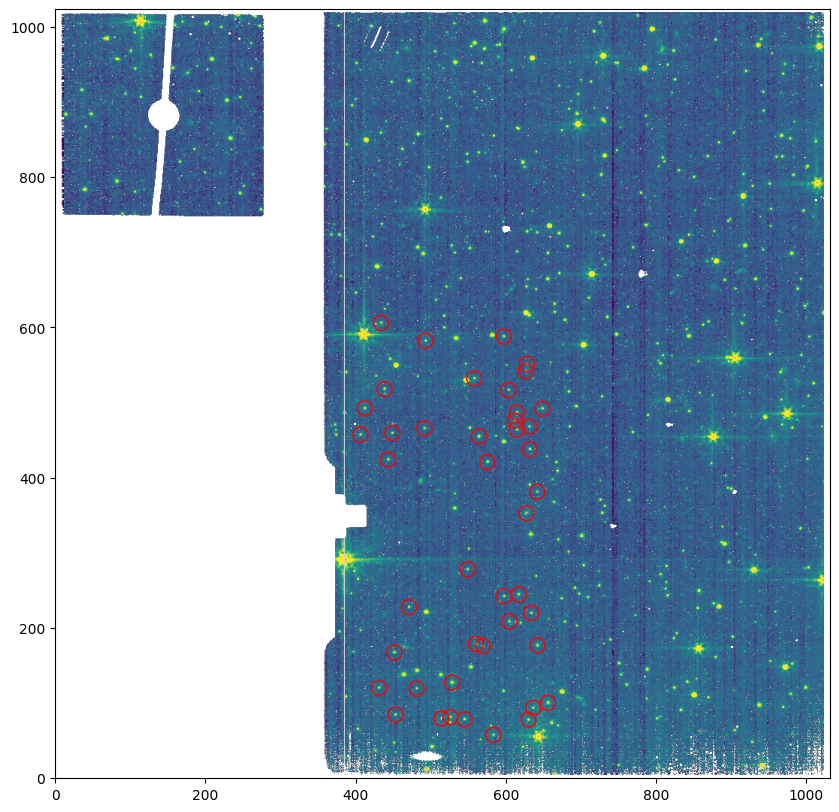

In [33]:
# plot the selected stars
norm = simple_norm(data.value, 'sqrt', percent=99)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data.value, origin='lower', norm=norm)

xypos = zip(init_params['x'], init_params['y'])
aper = CircularAperture(xypos, r=10)
aper.plot(ax, color='red')
plt.show()

In [34]:
fit_shape = 5
localbkg_estimator = LocalBackground(5, 10, bkg_estimator=MMMBackground())
psfphot = PSFPhotometry(psf_model, fit_shape, finder=None, aperture_radius=fit_shape, 
                        localbkg_estimator=localbkg_estimator, progress_bar=True)
phot = psfphot(data, error=error, init_params=init_params)
phot

<QTable length=44>
  id  group_id group_size ...        qfit                 cfit         flags
                          ...                                               
int64  int64     int64    ...      float64              float64        int64
----- -------- ---------- ... ------------------ --------------------- -----
    1        1          1 ...  1.592554525858295 -0.008029093203134859     0
    2        2          1 ... 1.8008472979147259   0.05008110417948685     0
    3        3          1 ... 1.3869661801118796   0.08939326254907773     0
    4        4          1 ... 1.4271814366031326   0.00254400481920013     1
    5        5          1 ... 1.4770514988460586   0.06073624762697728     0
    6        6          1 ... 2.2921925794144675   0.17402357161377432     0
    7        7          1 ... 2.0419826414367943    0.1729030083154531     0
    8        8          1 ... 0.7425576584319004   0.07986712430142177     0
    9        9          1 ...  2.412526246075053   0.08655417856521475     0
  ...      ...        ... ...                ...                   ...   ...
   36       36          1 ... 1.2044795601111933   0.07156229957054645     0
   37       37          1 ... 1.8726410278722834   0.08225042566395441     0
   38       38          1 ... 1.6292314338781626    0.0684033972255797     0
   39       39          1 ... 1.4269703915870038   0.03015436493065666     0
   40       40          1 ...  2.475724919321479    0.1541262984442095     0
   41       41          1 ... 2.2006463348774012  0.026898928342503625     0
   42       42          1 ...  2.245885366275252   0.13960944851282267     0
   43       43          1 ...  2.016375429048198 -0.005845087229945111     0
   44       44          1 ... 1.6630678103751408 -0.016245994910779434     0

In [35]:
# convert fit flux from uJy to ABmag
flux = phot['flux_fit']
flux_err = phot['flux_err']
mag = phot['flux_fit'].to(u.ABmag)
magerr = 2.5 * np.log10(1.0 + (flux_err / flux))
magerr = magerr.value * u.ABmag
mag, magerr

(<Magnitude [20.53968855, 20.35923527, 20.19987825, 20.43621318,
             20.33710108, 20.42916756, 20.4686352 , 19.55927662,
             20.69297761, 20.65126457, 19.32377519, 20.04306398,
             20.40416966, 19.70731474, 20.11691711, 20.29396076,
             20.44007513, 20.47336615, 20.48695953, 20.12105398,
             20.2501405 , 21.16800096, 20.79285496, 20.02802598,
             20.33465086, 20.34476846, 19.47693267, 20.36948414,
             20.43489364, 20.47643891, 20.41885784, 20.39525343,
             20.31342508, 20.14212217, 20.36406716, 20.11666339,
             20.56005081, 20.25848977, 20.60547547, 20.90063959,
             20.88533957, 20.55704325, 20.39033191, 20.68983748] mag(AB)>,
 <Magnitude [0.01093732, 0.01103697, 0.00994756, 0.01024699, 0.01047429,
             0.00978486, 0.01140736, 0.00651591, 0.01138331, 0.01133476,
             0.0065102 , 0.00798444, 0.00939263, 0.00744215, 0.00802427,
             0.00869982, 0.01027089, 0.00948007, 0.00967

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>